# 1. Setup

## 1.1 Imports

In [1]:
import os

import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf

import datetime

# actualizo libreria utils_macro
import bees_utils_macro as utils
import bees_utils_multitask as utils_multitask

## 1.2 Set random seeds

In [2]:
np.random.seed(117)
tf.random.set_seed(117)
#aunque se inicie la seed, los resultados no serán repetibles (debido al data augmentation, a los batches, etc)
#es importante promediar los resultados obtenidos

## 1.3 Global variables

In [3]:
img_width = 100
img_height = 100
img_channels = 3
input_shape = (img_height, img_width, img_channels)

# 2. Carga de datos

In [4]:
bees, bees_test_for_evaluation = utils.read_data()

In [5]:
bees.head()

,id,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,0,2018-08-06 14:48:00,020_011.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
1,1,2018-08-21 09:00:00,032_507.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
2,2,2018-08-21 09:00:00,032_612.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
3,3,2018-08-17 17:50:00,030_773.png,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
4,4,2018-08-06 13:19:00,015_1052.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [6]:
bees_test_for_evaluation.head()

,id,datetime,file,location,zip code,pollen_carrying,caste
0,0,2018-08-28 16:07:00,042_012.png,"Alvin, TX, USA",77511,False,worker
1,1,2018-08-10 13:54:00,022_114.png,"Saratoga, CA, USA",95070,False,worker
2,2,2018-08-18 12:30:00,038_384.png,"Athens, Georgia, USA",30607,False,worker
3,3,2018-08-17 17:50:00,030_740.png,"Alvin, TX, USA",77511,False,worker
4,4,2018-07-07 12:56:00,005_310.png,"Saratoga, CA, USA",95070,False,worker


# 3. Análisis exploratorio de datos

## 3.1 Análisis descriptivo: Distribuciones, Scatterplots, Barplots...

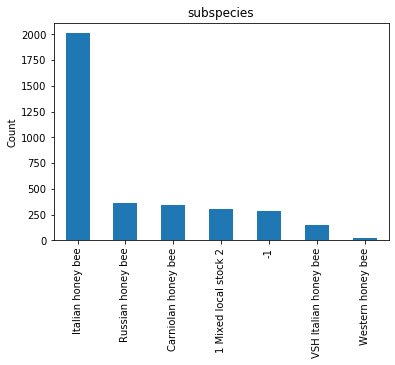

In [7]:
utils.value_counts(bees, 'subspecies')
# la subespecie "-1" es otra clase posible

## 3.2 Ver imágenes

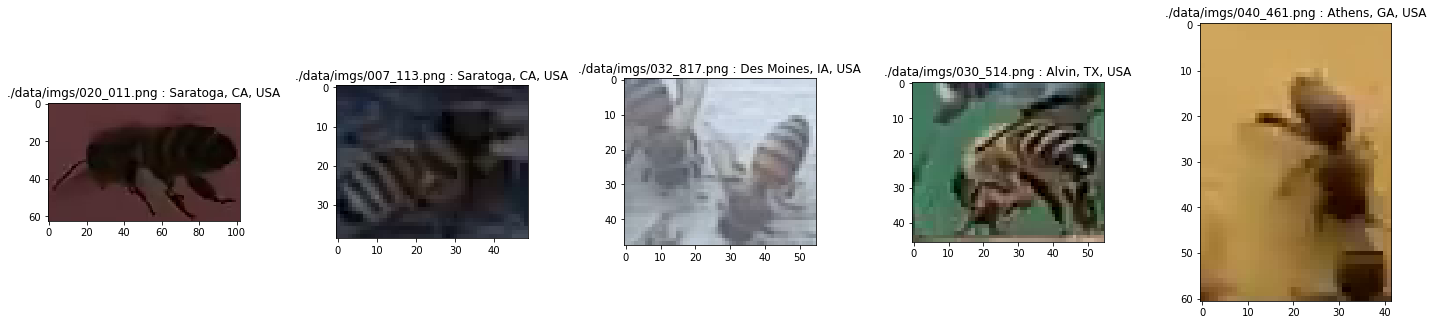

In [8]:
utils.plot_images(bees, 'location', [0, 18, 24, 38, 45])

# 4. Clasificación

## 4.1. Data preprocessing
### 4.1.1 Particionamiento

In [9]:
train_bees, val_bees, test_bees = utils.split(bees)


### 4.1.2 Carga de imágenes (multitask)

In [10]:
train_X, val_X, test_X, train_y, val_y, test_y = utils_multitask.load_images_and_target_multitask(train_bees, 
                                                                              val_bees, 
                                                                              test_bees,
                                                                              img_width, 
                                                                              img_height,
                                                                              img_channels)
#train_Y tiene tanto las clases de tipo de abejas como de health (en codificación one-hot)

In [11]:
train_X.shape

(2338, 100, 100, 3)

## 4.2 CNN (functional)

In [12]:
class_weights_subspecies = utils.class_weights(bees, 'subspecies')
class_weights_subspecies

array([ 1.75531915,  1.64451827,  1.43895349,  0.24626866,  1.375     ,
        3.39041096, 22.5       ])

In [13]:
output_size_subspecies = class_weights_subspecies.size
output_size_subspecies

7

In [14]:
class_weights_health = utils.class_weights(bees, 'health')
class_weights_health

array([ 1.91860465,  1.81603774,  1.53590426,  0.25185347,  3.72580645,
       26.25      ])

In [15]:
output_size_health = class_weights_health.size
output_size_health

6

In [16]:
losses = utils_multitask.get_losses([
                            utils_multitask.get_class_weights_matrix(class_weights_subspecies),
                            utils_multitask.get_class_weights_matrix(class_weights_health)
                        ], 
                        ['output1', 'output2']) 
losses

{'output1': functools.partial(<function weighted_categorical_crossentropy at 0x7f23a1d294d0>, weights=array([[ 0.        ,  1.75531915,  1.75531915,  1.75531915,  1.75531915,
          1.75531915,  1.75531915],
        [ 1.64451827,  0.        ,  1.64451827,  1.64451827,  1.64451827,
          1.64451827,  1.64451827],
        [ 1.43895349,  1.43895349,  0.        ,  1.43895349,  1.43895349,
          1.43895349,  1.43895349],
        [ 0.24626866,  0.24626866,  0.24626866,  0.        ,  0.24626866,
          0.24626866,  0.24626866],
        [ 1.375     ,  1.375     ,  1.375     ,  1.375     ,  0.        ,
          1.375     ,  1.375     ],
        [ 3.39041096,  3.39041096,  3.39041096,  3.39041096,  3.39041096,
          0.        ,  3.39041096],
        [22.5       , 22.5       , 22.5       , 22.5       , 22.5       ,
         22.5       ,  0.        ]])),
 'output2': functools.partial(<function weighted_categorical_crossentropy at 0x7f23a1d294d0>, weights=array([[ 0.        ,  1.

In [17]:
optimizer = 'adam'
#usar como optimizador adam

In [18]:
inputs = Input(input_shape)
#model1.add(Input((img_height, img_width, img_channels)))
#flatten1 y flatten2 hacen la bifurcación de "inputs"

# y1 modelo subespecies
y1 = Conv2D(64, kernel_size=3, padding='same')(inputs)
y1 = Activation('relu')(y1)
y1 = MaxPool2D(2)(y1)
y1 = Dropout(0.2)(y1)

y1 = Conv2D(32, kernel_size=3, padding='same')(y1)
y1 = Activation('relu')(y1)
y1 = MaxPool2D(2)(y1)
y1 = Dropout(0.2)(y1)

y1 = Flatten()(y1)

#y2 modelo health
y2 = Conv2D(32, kernel_size=3, padding='same')(inputs)
y2 = Activation('relu')(y2)
y2 = MaxPool2D(2)(y2)
y2 = Dropout(0.1)(y2)

y2 = Conv2D(32, kernel_size=3, padding='same')(y2)
y2 = Activation('relu')(y2)
y2 = MaxPool2D(2)(y2)
y2 = Dropout(0.1)(y2)

y2 = Conv2D(64, kernel_size=3, padding='same')(y2)
y2 = Activation('relu')(y2)
y2 = MaxPool2D(2)(y2)
y2 = Dropout(0.1)(y2)
 
y2 = Flatten()(y2)

y2 = Dense(512, activation = 'relu')(y2)
y2 = Dropout(0.1)(y2)


output1 = Dense(output_size_subspecies, activation = 'softmax', name = 'output1')(y1)
output2 = Dense(output_size_health, activation = 'softmax', name = 'output2')(y2)
model1 = Model(inputs, [output1, output2])

model1.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy'])
#después cambiar la métrica por "macro avergae recall"

In [19]:
model1.build(input_shape)
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 100, 100, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 100, 100, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 50, 50, 32)   0           activation_2[0][0]               
_______________________________________________________________________________________

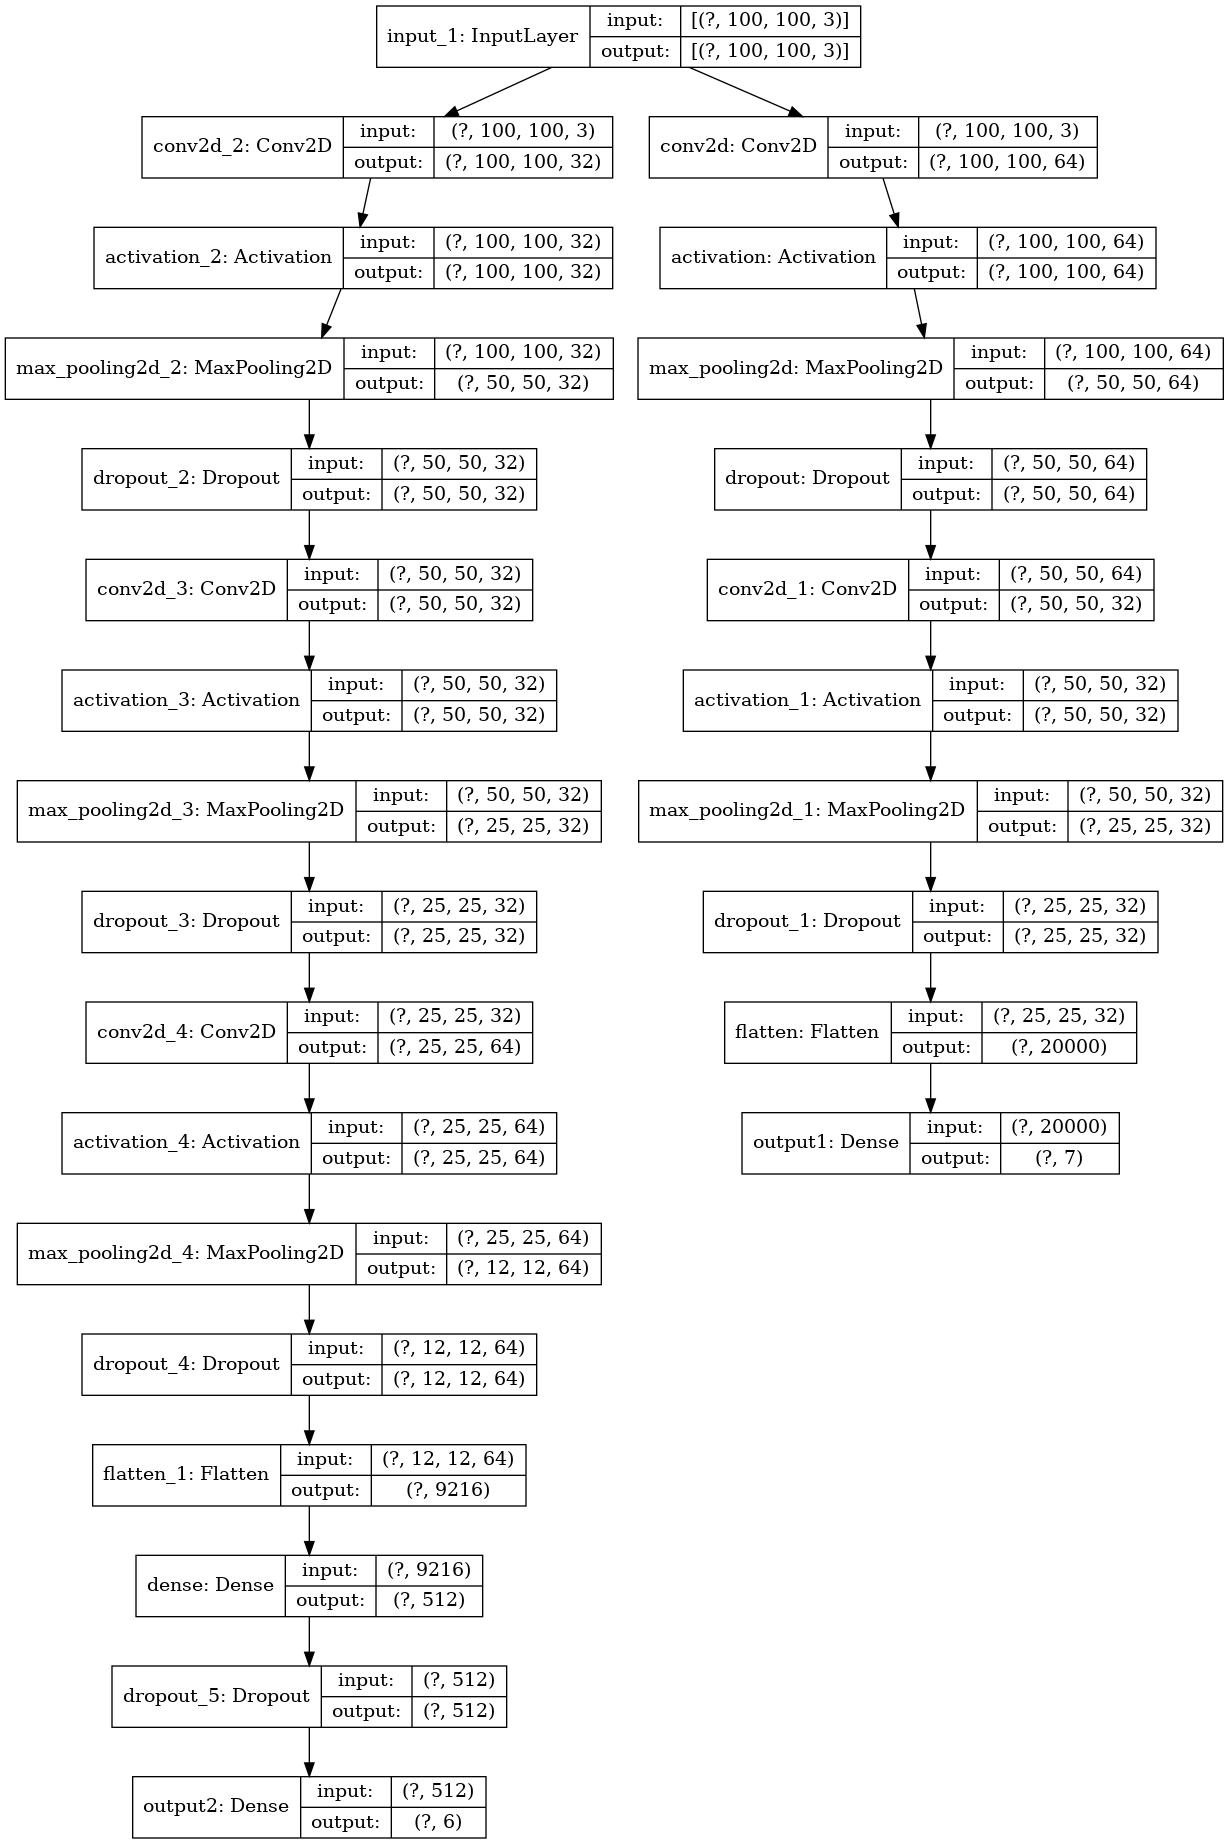

In [20]:
keras.utils.plot_model(model1, show_shapes = True)

In [21]:
model1.evaluate(test_X, test_y)

28/28 [==============================] - 1s 34ms/step - loss: 24.3433 - output1_loss: 12.9691 - output2_loss: 11.3742 - output1_accuracy: 0.0473 - output2_accuracy: 0.4406


[24.343290328979492,
 12.969109535217285,
 11.374176979064941,
 0.04728950560092926,
 0.4405997693538666]

In [22]:
test_X.shape

(867, 100, 100, 3)

In [23]:
test_y

[       0    1    2    3    4    5    6
 0    0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1    0.0  0.0  0.0  1.0  0.0  0.0  0.0
 2    1.0  0.0  0.0  0.0  0.0  0.0  0.0
 3    0.0  1.0  0.0  0.0  0.0  0.0  0.0
 4    0.0  0.0  0.0  0.0  1.0  0.0  0.0
 ..   ...  ...  ...  ...  ...  ...  ...
 862  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 863  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 864  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 865  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 866  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 
 [867 rows x 7 columns],
        0    1    2    3    4    5
 0    0.0  0.0  0.0  1.0  0.0  0.0
 1    0.0  0.0  1.0  0.0  0.0  0.0
 2    0.0  0.0  0.0  0.0  1.0  0.0
 3    1.0  0.0  0.0  0.0  0.0  0.0
 4    0.0  0.0  0.0  1.0  0.0  0.0
 ..   ...  ...  ...  ...  ...  ...
 862  0.0  0.0  0.0  1.0  0.0  0.0
 863  0.0  0.0  0.0  1.0  0.0  0.0
 864  0.0  1.0  0.0  0.0  0.0  0.0
 865  0.0  0.0  0.0  1.0  0.0  0.0
 866  0.0  0.0  0.0  1.0  0.0  0.0
 
 [867 rows x 6 columns]]

## 4.3 Entrenamiento

### 4.2.2 Parámetros de transformación de imágenes (data augmentation)

In [24]:
rotation_range =  180      # rotación aleatoria en grados entre 0 a rotation_range
zoom_range = 0.1           # zoom aleatorio
width_shift_range = 0.2    # desplazamiento horizontal aleatorio (fracción del total)
height_shift_range = 0.2   # desplazamiento vertical aleatorio (fracción del total)
horizontal_flip = True  # transposición horizontal
vertical_flip = True   # transposición horizontal

In [25]:
batch_size = 70
epochs = 160
#defino un nuevo valor de steps_per_epoch así trabajo solo con batch_size
#steps_per_epoch = train_X.shape[0] // batch_size
steps_per_epoch = 150
patience = 10

In [26]:
steps_per_epoch

150

In [27]:
# Callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=patience, verbose=1,restore_best_weights=True)
callbacks = [earlystopper]

In [28]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TBLOGDIRS = {'multitask': 'logs/multitask/Bees_'}
TBLOGDIRS = {k:v+current_time for (k,v) in TBLOGDIRS.items()}
tensorboard = TensorBoard(TBLOGDIRS['multitask'], histogram_freq = 1)
#!rm -r logs/multitask/*

In [29]:
training1, model1 = utils_multitask.train(model1,
                train_X,
                train_y, 
                batch_size = batch_size,
                epochs = epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data_X = val_X, 
                validation_data_y = val_y,
                rotation_range = rotation_range,
                zoom_range = zoom_range, 
                width_shift_range = width_shift_range,
                height_shift_range = height_shift_range,
                horizontal_flip = horizontal_flip,  
                vertical_flip = vertical_flip,
                callbacks = callbacks)

Epoch 1/160
150/150 [==============================] - 47s 313ms/step - loss: 14.8163 - output1_loss: 6.7214 - output2_loss: 8.0949 - output1_accuracy: 0.4467 - output2_accuracy: 0.4203 - val_loss: 9.7149 - val_output1_loss: 3.5733 - val_output2_loss: 6.1416 - val_output1_accuracy: 0.6769 - val_output2_accuracy: 0.6077
Epoch 2/160
150/150 [==============================] - 47s 310ms/step - loss: 6.7646 - output1_loss: 2.5890 - output2_loss: 4.1756 - output1_accuracy: 0.7009 - output2_accuracy: 0.5894 - val_loss: 8.2058 - val_output1_loss: 2.6170 - val_output2_loss: 5.5888 - val_output1_accuracy: 0.5885 - val_output2_accuracy: 0.4769
Epoch 3/160
150/150 [==============================] - 47s 311ms/step - loss: 5.5832 - output1_loss: 2.1499 - output2_loss: 3.4333 - output1_accuracy: 0.7389 - output2_accuracy: 0.6660 - val_loss: 4.9234 - val_output1_loss: 1.5442 - val_output2_loss: 3.3792 - val_output1_accuracy: 0.6962 - val_output2_accuracy: 0.7269
Epoch 4/160
150/150 [==================

150/150 [==============================] - 44s 295ms/step - loss: 3.8063 - output1_loss: 1.7002 - output2_loss: 2.1061 - output1_accuracy: 0.7722 - output2_accuracy: 0.7912 - val_loss: 3.4091 - val_output1_loss: 1.4553 - val_output2_loss: 1.9538 - val_output1_accuracy: 0.5923 - val_output2_accuracy: 0.8269
Epoch 00026: early stopping


## 4.3 Evaluación del modelo

In [30]:
utils_multitask.eval_model(training1, model1, test_X, test_y)

Classification report
                       precision    recall  f1-score   support

                   -1       0.86      0.86      0.86        70
1 Mixed local stock 2       0.44      0.96      0.61        69
  Carniolan honey bee       0.89      0.95      0.92        92
    Italian honey bee       0.98      0.81      0.88       490
    Russian honey bee       0.96      0.89      0.92       110
VSH Italian honey bee       0.83      1.00      0.91        29
    Western honey bee       0.70      1.00      0.82         7

             accuracy                           0.86       867
            macro avg       0.81      0.92      0.85       867
         weighted avg       0.91      0.86      0.87       867

                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.65      0.52      0.58        69
              ant problems       0.95      0.96      0.96        84
  few varrao, hive beetles       0.62      0.77      0.69        81
         

In [31]:
df_subspecies, df_health = utils_multitask.load_test_and_generate_prediction_file(model1, img_width, img_height, img_channels)

In [32]:
df_subspecies

,id,expected
0,0,-1
1,1,Italian honey bee
2,2,1 Mixed local stock 2
3,3,Italian honey bee
4,4,Italian honey bee
...,...,...
1702,1702,Italian honey bee
1703,1703,1 Mixed local stock 2
1704,1704,Italian honey bee
1705,1705,Carniolan honey bee


In [33]:
df_health

,id,expected
0,0,hive being robbed
1,1,healthy
2,2,"few varrao, hive beetles"
3,3,ant problems
4,4,healthy
...,...,...
1702,1702,healthy
1703,1703,"few varrao, hive beetles"
1704,1704,ant problems
1705,1705,healthy
